# Import Libraries

In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as k

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)


# Verify TensorFlow version and Keras version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.12.0


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.12.0


# Mount Google Drive to Colab environment

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Research Assignment Reporting Functions

In [6]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

# Loading MNIST Dataset


In [7]:
(train_val_images, train_val_labels), (X_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


# Split train dataset into train and validation data

In [8]:
X_train, X_val, y_train, y_val = train_test_split(train_val_images, train_val_labels, test_size=5000, random_state=42)

# Explore Shape of Data

In [9]:
print('X_train:\t{}'.format(X_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('X_val:\t\t{}'.format(X_val.shape))
print('y_val:\t\t{}'.format(y_val.shape))
print('X_test:\t\t{}'.format(X_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))

X_train:	(55000, 28, 28)
y_train:	(55000,)
X_val:		(5000, 28, 28)
y_val:		(5000,)
X_test:		(10000, 28, 28)
y_test:		(10000,)


# EDA



# Preprocessing Data

* Before we build our model, we need to prepare the data into the shape the network expected
* More specifically, we will convert the labels (integers 0 to 9) to 1D numpy arrays of shape (10,) with elements 0s and 1s.
* We also reshape the images from 2D arrays of shape (28,28) to 1D float32 arrays of shape (784,) and then rescale their elements to values between 0 and 1.

## Apply one-hot encoding on the labels
We will change the way the labels are represented from numbers (0 to 9) to vectors (1D arrays) of shape (10, ) with all the elements set to 0 except the one which the label belongs to - which will be set to 1. For example:

| original label | one-hot encoded label|
---------------- | ----------------------
5	| [0 0 0 0 0 1 0 0 0 0]
7	| [0 0 0 0 0 0 0 1 0 0]
1	| [0 1 0 0 0 0 0 0 0 0]

In [10]:
y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)
y_test_encoded = to_categorical(y_test)

print("First ten entries of y_train:\n {}\n".format(y_train[0:10]))
print("First ten rows of one-hot y_train:\n {}".format(y_train_encoded[0:10,]))

First ten entries of y_train:
 [7 2 2 4 1 4 0 4 9 1]

First ten rows of one-hot y_train:
 [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [11]:
print('y_train_encoded shape: ', y_train_encoded.shape)
print('y_val_encoded shape: ', y_val_encoded.shape)
print('y_test_encoded shape: ', y_test_encoded.shape)

y_train_encoded shape:  (55000, 10)
y_val_encoded shape:  (5000, 10)
y_test_encoded shape:  (10000, 10)


# Reshape the images to 1D arrays
Reshape the images from shape (28, 28) 2D arrays to shape (784, ) vectors (1D arrays).

In [12]:
# Before reshape:
print('X_train:\t{}'.format(X_train.shape))
print('X_val:\t\t{}'.format(X_val.shape))
print('X_test:\t\t{}'.format(X_test.shape))

X_train:	(55000, 28, 28)
X_val:		(5000, 28, 28)
X_test:		(10000, 28, 28)


In [13]:
# Reshape the images:
X_train_reshaped = np.reshape(X_train, (55000, 784))
X_val_reshaped = np.reshape(X_val, (5000, 784))
X_test_reshaped = np.reshape(X_test, (10000, 784))

# After reshape:
print('X_train_reshaped shape: ', X_train_reshaped.shape)
print('X_val_reshaped shape: ', X_val_reshaped.shape)
print('X_test_reshaped shape: ', X_test_reshaped.shape)

X_train_reshaped shape:  (55000, 784)
X_val_reshaped shape:  (5000, 784)
X_test_reshaped shape:  (10000, 784)


# Rescale Pixel Values

1. Each element in an image is a pixel value
2. Pixel values range from 0 to 255
3. 0 = White
4. 255 = Black

In [14]:
print(set(X_train_reshaped[0]))

{0, 8, 139, 11, 13, 144, 20, 149, 25, 27, 30, 32, 162, 38, 43, 48, 176, 181, 55, 56, 183, 58, 59, 60, 61, 191, 193, 196, 80, 214, 87, 218, 247, 120, 93, 220, 96, 99, 228, 230, 231, 232, 105, 102, 235, 236, 237, 110, 112, 241, 243, 115, 118, 119, 248, 249, 250, 251, 253, 254}


In [15]:
X_train_norm = X_train_reshaped.astype('float32') / 255
X_val_norm = X_val_reshaped.astype('float32') / 255
X_test_norm = X_test_reshaped.astype('float32') / 255

In [16]:
# Take a look at the first reshaped and normalized training image:
print(set(X_train_norm[0]))

{0.0, 0.9529412, 0.4392157, 0.94509804, 0.7490196, 0.3137255, 0.99607843, 0.99215686, 0.972549, 0.92156863, 0.5647059, 0.4117647, 0.1882353, 0.09803922, 0.3647059, 0.58431375, 0.9098039, 0.8392157, 0.4509804, 0.23137255, 0.90588236, 0.98039216, 0.34117648, 0.21568628, 0.23921569, 0.22745098, 0.3882353, 0.9254902, 0.76862746, 0.050980393, 0.1254902, 0.54509807, 0.63529414, 0.70980394, 0.03137255, 0.14901961, 0.4, 0.9843137, 0.8627451, 0.9019608, 0.9764706, 0.75686276, 0.6901961, 0.96862745, 0.89411765, 0.7176471, 0.85490197, 0.043137256, 0.92941177, 0.43137255, 0.3764706, 0.11764706, 0.105882354, 0.078431375, 0.23529412, 0.21960784, 0.16862746, 0.4627451, 0.46666667, 0.47058824}


In [17]:
pca = PCA(n_components=154)
pca.fit(np.concatenate((X_train_norm, X_val_norm), axis=0))



PCA(n_components=154)

In [18]:
explained_variance_ratios = pca.explained_variance_ratio_

# Calculate the cumulative sum of explained variance ratios
cumulative_variance_ratios = np.cumsum(explained_variance_ratios)
for i, variance_ratio in enumerate(explained_variance_ratios):
    print(f"Component {i+1}: {variance_ratio:.4f}")


Component 1: 0.0970
Component 2: 0.0710
Component 3: 0.0617
Component 4: 0.0539
Component 5: 0.0487
Component 6: 0.0431
Component 7: 0.0327
Component 8: 0.0288
Component 9: 0.0276
Component 10: 0.0236
Component 11: 0.0211
Component 12: 0.0202
Component 13: 0.0172
Component 14: 0.0169
Component 15: 0.0158
Component 16: 0.0148
Component 17: 0.0132
Component 18: 0.0128
Component 19: 0.0119
Component 20: 0.0115
Component 21: 0.0107
Component 22: 0.0101
Component 23: 0.0095
Component 24: 0.0091
Component 25: 0.0088
Component 26: 0.0084
Component 27: 0.0081
Component 28: 0.0079
Component 29: 0.0074
Component 30: 0.0069
Component 31: 0.0066
Component 32: 0.0065
Component 33: 0.0060
Component 34: 0.0059
Component 35: 0.0057
Component 36: 0.0054
Component 37: 0.0051
Component 38: 0.0049
Component 39: 0.0048
Component 40: 0.0047
Component 41: 0.0046
Component 42: 0.0044
Component 43: 0.0042
Component 44: 0.0040
Component 45: 0.0038
Component 46: 0.0038
Component 47: 0.0036
Component 48: 0.0035
C

In [19]:
print("\nCumulative explained variance ratios:")
for i, cumulative_variance_ratio in enumerate(cumulative_variance_ratios):
    print(f"Components {i+1}: {cumulative_variance_ratio:.4f}")


Cumulative explained variance ratios:
Components 1: 0.0970
Components 2: 0.1680
Components 3: 0.2297
Components 4: 0.2836
Components 5: 0.3323
Components 6: 0.3754
Components 7: 0.4081
Components 8: 0.4370
Components 9: 0.4646
Components 10: 0.4882
Components 11: 0.5092
Components 12: 0.5295
Components 13: 0.5466
Components 14: 0.5636
Components 15: 0.5793
Components 16: 0.5942
Components 17: 0.6074
Components 18: 0.6202
Components 19: 0.6321
Components 20: 0.6436
Components 21: 0.6542
Components 22: 0.6643
Components 23: 0.6739
Components 24: 0.6830
Components 25: 0.6918
Components 26: 0.7002
Components 27: 0.7083
Components 28: 0.7162
Components 29: 0.7236
Components 30: 0.7305
Components 31: 0.7371
Components 32: 0.7436
Components 33: 0.7496
Components 34: 0.7555
Components 35: 0.7612
Components 36: 0.7666
Components 37: 0.7717
Components 38: 0.7766
Components 39: 0.7814
Components 40: 0.7861
Components 41: 0.7907
Components 42: 0.7951
Components 43: 0.7993
Components 44: 0.8033
Co

In [20]:
X_train_pca = pca.transform(X_train_norm)
X_val_pca = pca.transform(X_val_norm)
X_test_pca = pca.transform(X_test_norm)



In [21]:
X_train_pca.shape

(55000, 154)

In [22]:
nodes = 1024
model = Sequential()
model.add(Dense(input_shape=[154,], units=nodes, activation=tf.nn.relu))
model.add(Dense(name="output_layer", units=10, activation=tf.nn.softmax))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              158720    
                                                                 
 output_layer (Dense)        (None, 10)                10250     
                                                                 
Total params: 168,970
Trainable params: 168,970
Non-trainable params: 0
_________________________________________________________________


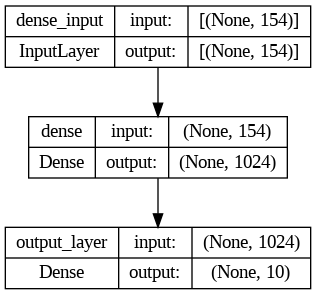

In [24]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True)

In [25]:
model.compile(optimizer='rmsprop',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [26]:
history = model.fit(X_train_pca, y_train_encoded,
          validation_data=(X_val_pca, y_val_encoded),
          epochs=200,
          callbacks=[tf.keras.callbacks.ModelCheckpoint("/content/drive/DNN_model_04.h5",save_best_only=True, save_weights_only=False),
                     tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)]
    )

Epoch 1/200
1719/1719 [==============================] - 11s 3ms/step - loss: 0.1882 - accuracy: 0.9478 - val_loss: 0.1024 - val_accuracy: 0.9676
Epoch 2/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0669 - accuracy: 0.9802 - val_loss: 0.0745 - val_accuracy: 0.9790
Epoch 3/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0354 - accuracy: 0.9895 - val_loss: 0.0725 - val_accuracy: 0.9786
Epoch 4/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0208 - accuracy: 0.9938 - val_loss: 0.0715 - val_accuracy: 0.9804
Epoch 5/200
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0106 - accuracy: 0.9970 - val_loss: 0.0800 - val_accuracy: 0.9806
Epoch 6/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0058 - accuracy: 0.9985 - val_loss: 0.0765 - val_accuracy: 0.9822
Epoch 7/200
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0812 - val_a

# Evaluate the Model

In [27]:
model = tf.keras.models.load_model("/content/drive/DNN_model_04.h5")
print(f"Test acc: {model.evaluate(X_test_pca, y_test_encoded)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.0637 - accuracy: 0.9826
Test acc: 0.983


In [28]:
loss, accuracy = model.evaluate(X_test_pca, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 2ms/step - loss: 0.0637 - accuracy: 0.9826
test set accuracy:  98.25999736785889


# Making Predictions

In [29]:
preds = model.predict(X_test_pca)
print('shape of preds: ', preds.shape)

313/313 [==============================] - 0s 1ms/step
shape of preds:  (10000, 10)


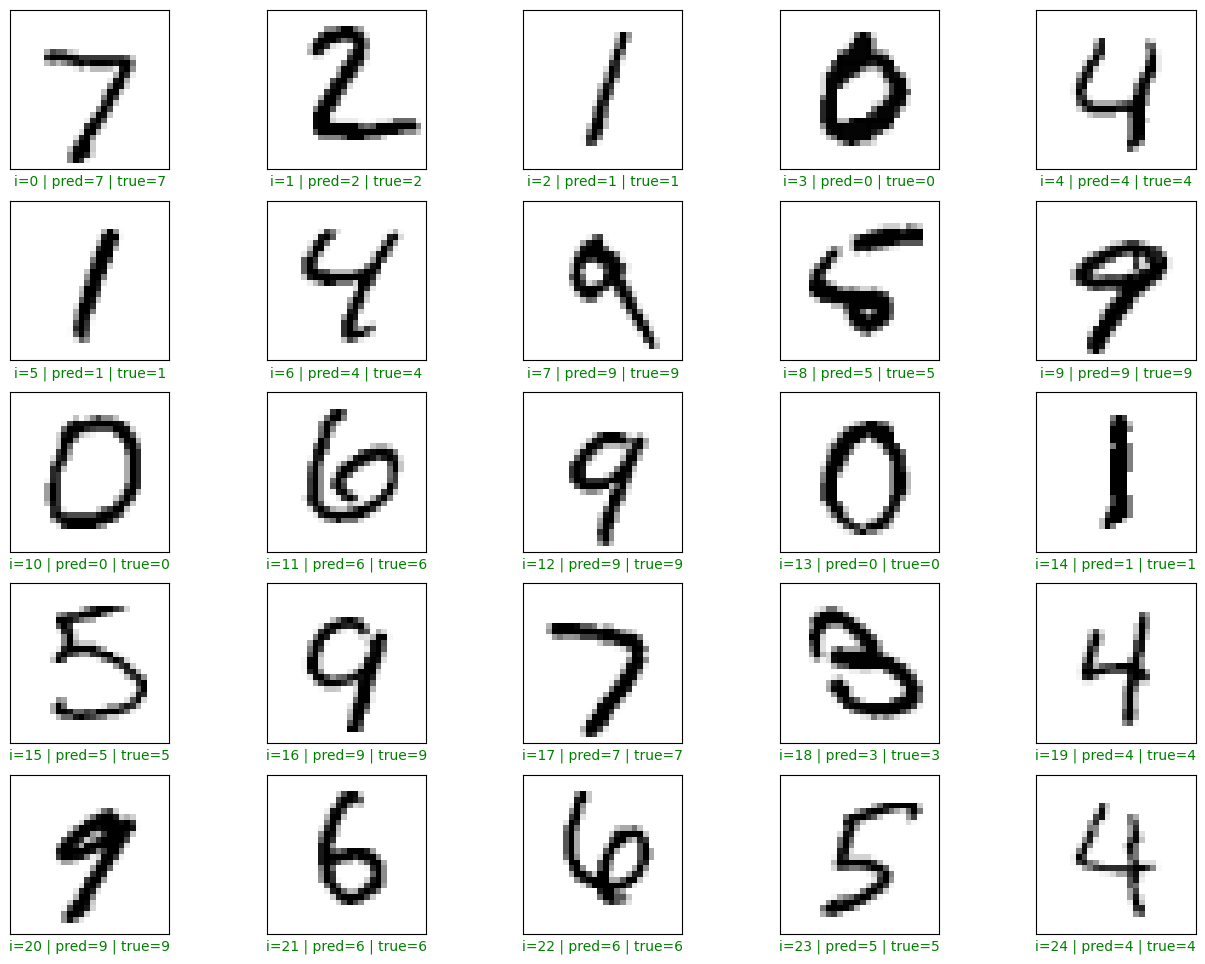

In [30]:
plt.figure(figsize = (16, 12))

start_index = 0

# plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(X_test[start_index + i], cmap='binary')
plt.show()

# Reviewing Performance

In [31]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [33]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
15,0.0,1.0,0.083,0.984
16,0.0,1.0,0.084,0.984
17,0.0,1.0,0.084,0.984
18,0.0,1.0,0.084,0.984
19,0.0,1.0,0.084,0.984


<ipython-input-34-8a5a046bfb84>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


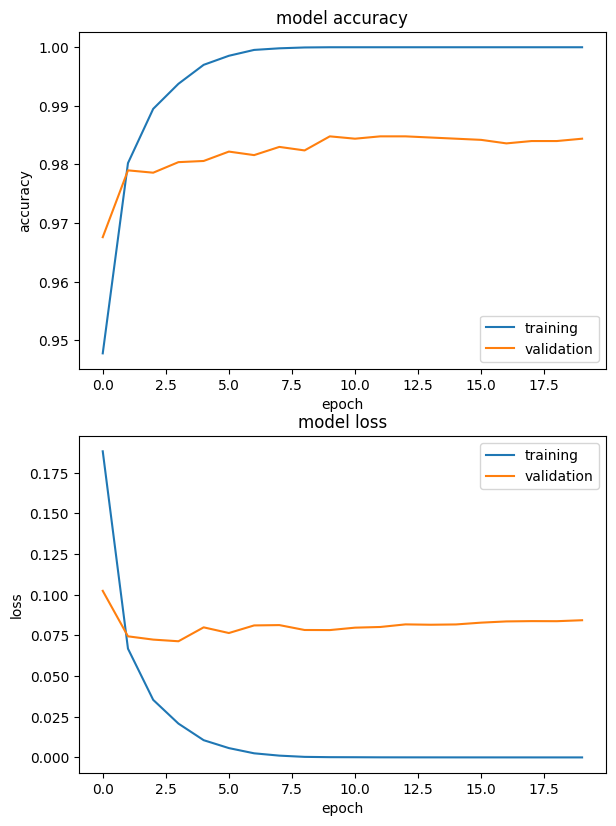

In [34]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(6,8))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [35]:
pred1= model.predict(X_test_pca)
pred1=np.argmax(pred1, axis=1)

313/313 [==============================] - 0s 1ms/step


In [36]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.99      0.98      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Accuracy Score: 0.9826
Root Mean Square Error: 0.5814636704042653


# Create the confusion matrix

In [37]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(X_test_pca), axis=-1)
pred_classes;

313/313 [==============================] - 0s 1ms/step


In [38]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

In [39]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9
0,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,100.00%,0.00%,0.00%
1,0.00%,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
2,0.00%,99.91%,0.00%,0.00%,0.02%,0.00%,0.00%,0.03%,0.04%,0.00%
3,99.99%,0.00%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
4,0.00%,0.00%,0.00%,0.00%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%
5,0.00%,99.98%,0.00%,0.00%,0.00%,0.00%,0.00%,0.02%,0.00%,0.00%
6,0.00%,0.00%,0.00%,0.00%,99.99%,0.00%,0.00%,0.00%,0.01%,0.00%
7,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,99.99%
8,0.00%,0.00%,0.00%,0.00%,0.00%,57.91%,42.09%,0.00%,0.00%,0.00%
9,0.00%,0.00%,0.00%,0.00%,0.03%,0.00%,0.00%,0.01%,0.01%,99.96%


# Visualize Confusion Matrix

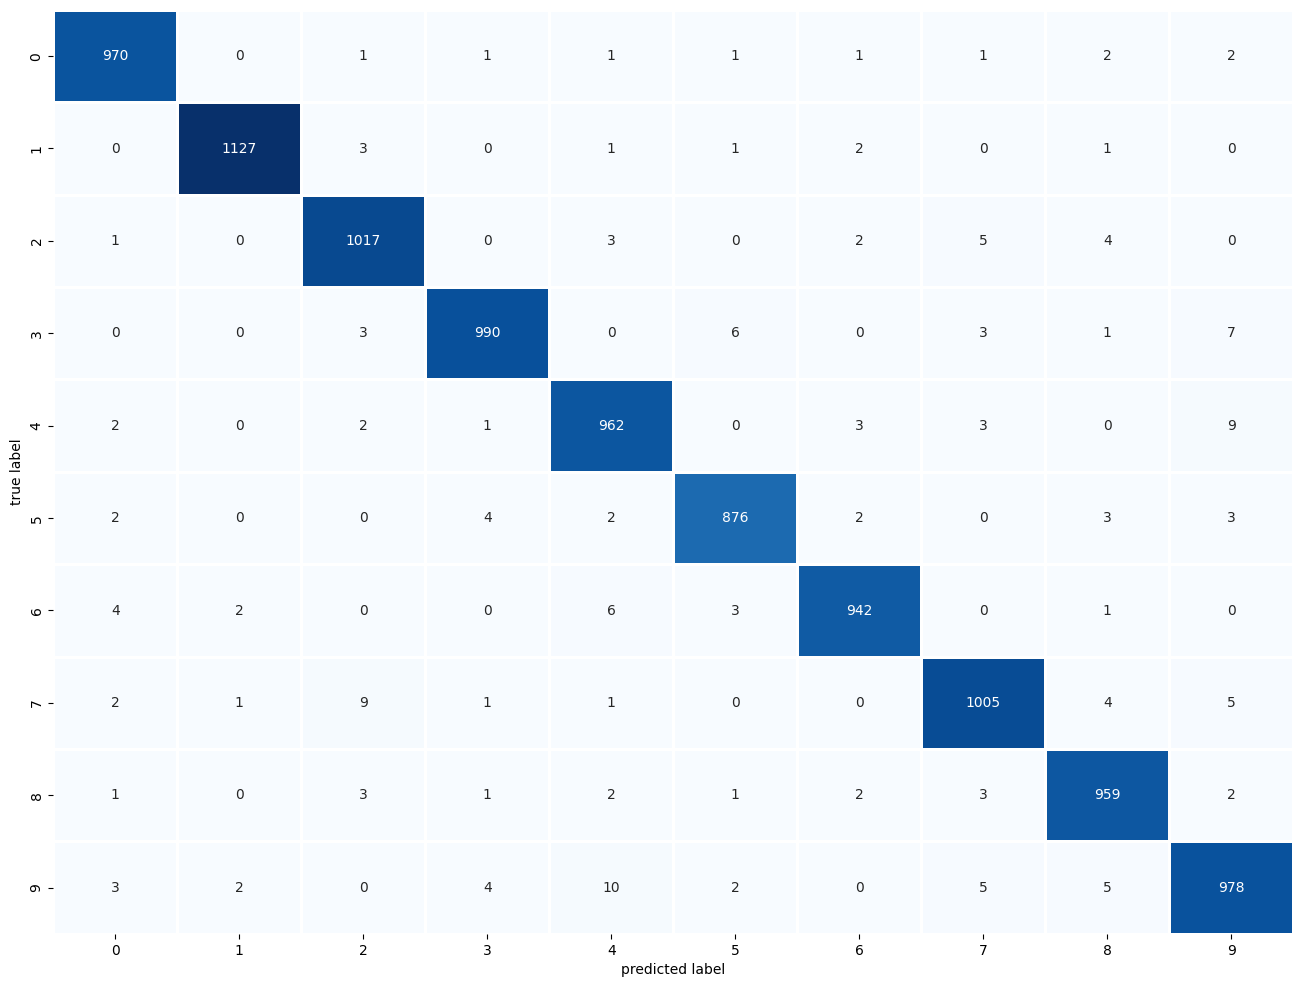

In [40]:
plot_confusion_matrix(y_test, pred_classes)

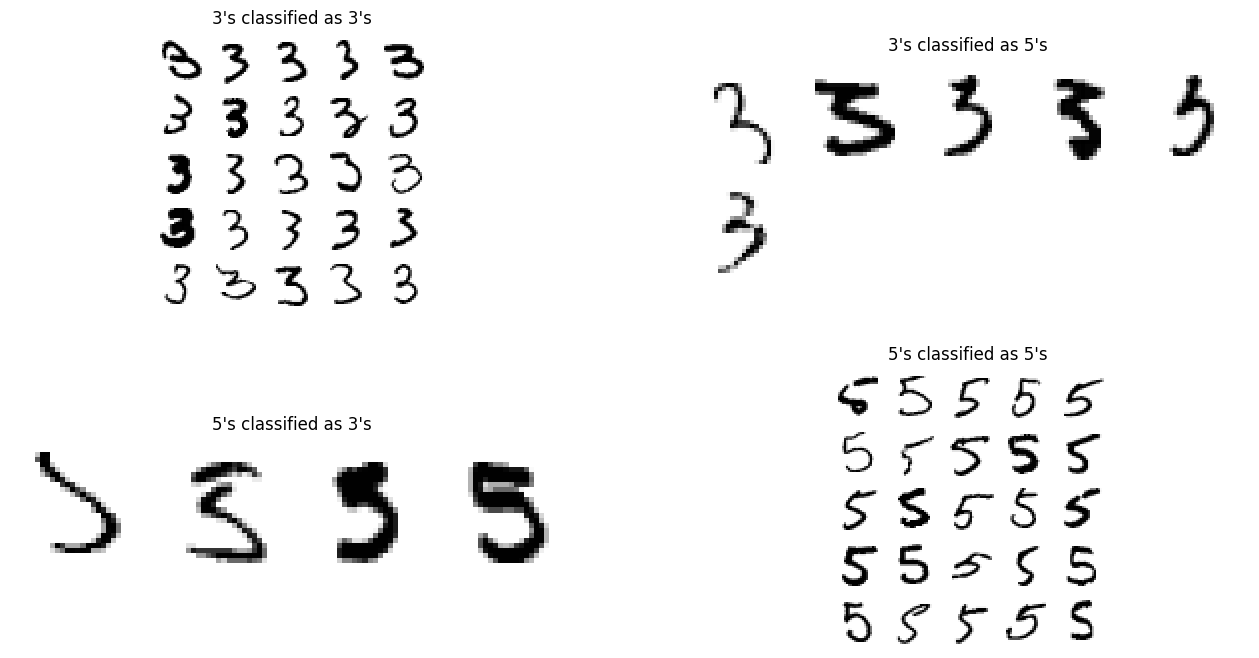

In [41]:
cl_a, cl_b = 3,5
X_aa = X_test_norm[(y_test == cl_a) & (pred_classes == cl_a)]
X_ab = X_test_norm[(y_test == cl_a) & (pred_classes == cl_b)]
X_ba = X_test_norm[(y_test == cl_b) & (pred_classes == cl_a)]
X_bb = X_test_norm[(y_test == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(16,8))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()